### Soccermatics -Expected Danger Football Project
### By: Mabel Fafali Kwadzo

Loading JSON files...


100%|██████████| 380/380 [00:50<00:00,  7.46it/s]


Total events loaded: 630,260
Passes: 320,903, Shots: 8,750

1. Identifying danger passes (passes within 15 seconds of a shot)...


100%|██████████| 380/380 [00:22<00:00, 16.94it/s]


Danger passes identified: 23,477

2. Feature engineering for logistic regression...
2. Fitting logistic regression for shot probability...
Logistic regression accuracy: 0.926

3. Fitting linear regression for goal probability...
Linear regression R² score: 0.029

4. Computing Expected Danger (xD)...
xD calculation complete

5. Aggregating player statistics and ranking by position...

Creating comprehensive football visualization...


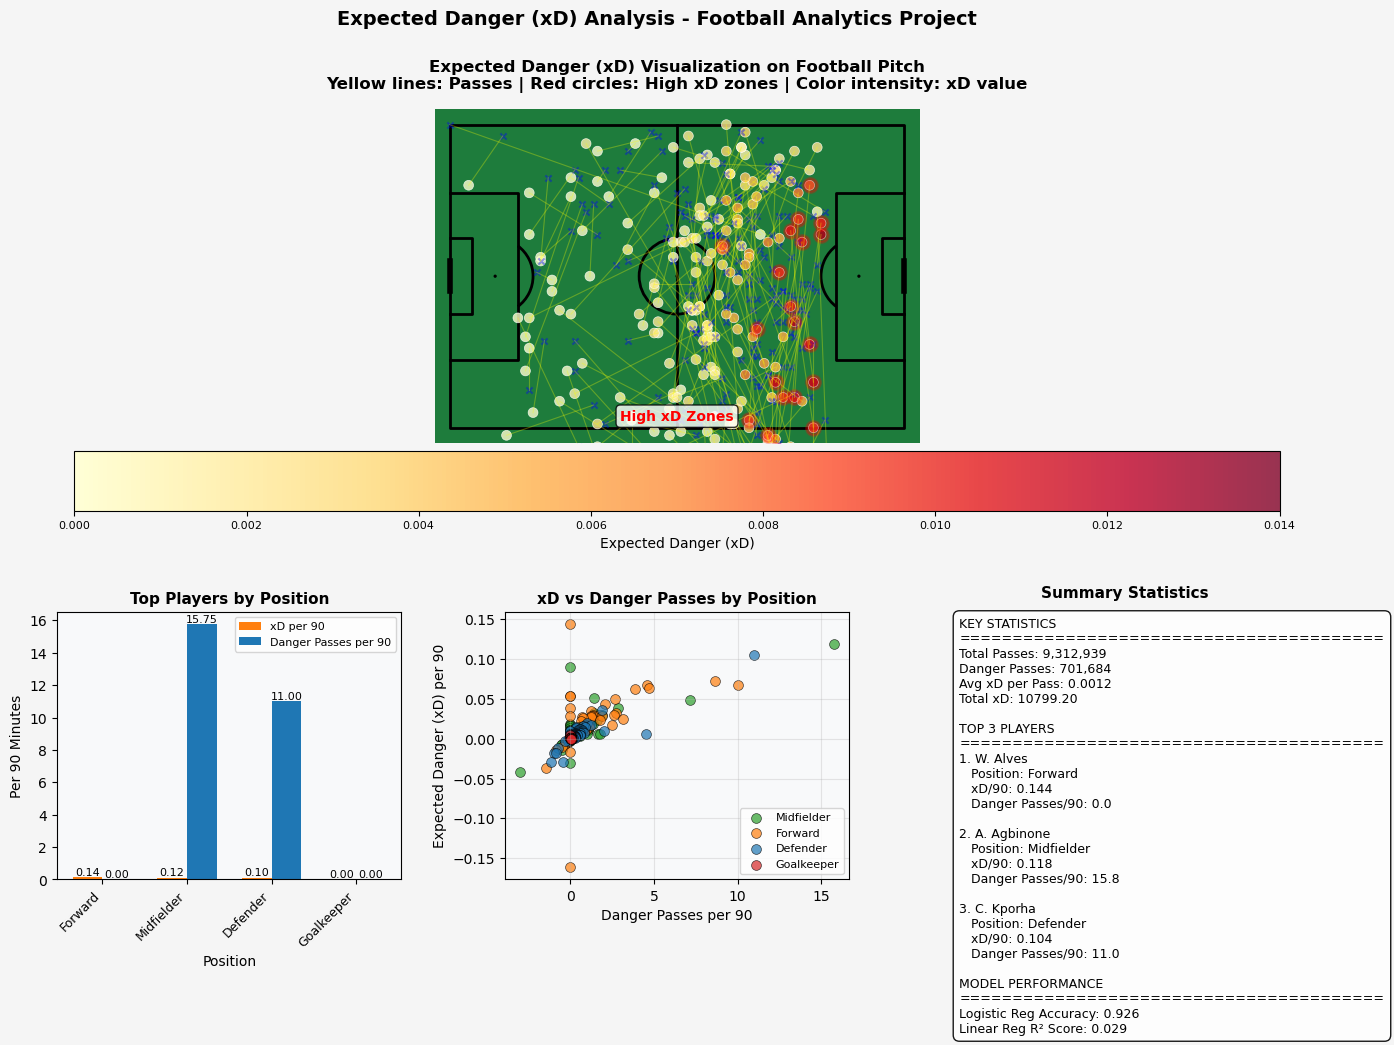


Saving results...
Player rankings saved to: player_xD_rankings.csv
Visualization saved to: football_xD_analysis.png
Report saved to: xD_analysis_report.txt

PROJECT COMPLETED SUCCESSFULLY

All requirements implemented:
1. Identified passes leading to shots within 15 seconds
2. Logistic regression with polynomial features for shot probability
3. Linear regression for goal probability
4. Expected Danger (xD) calculated
5. Players ranked by position for xD per 90 vs danger passes per 90

Output files created:
1. football_xD_analysis.png - Comprehensive football visualization
2. player_xD_rankings.csv - Player statistics and rankings
3. xD_analysis_report.txt - Analysis report with findings

Run completed successfully!


In [ ]:
# =========================================
# EXPECTED DANGER (xD) - PROJECT VERSION
# =========================================
#importing Libraries

import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LinearRegression

import matplotlib.pyplot as plt
from mplsoccer import Pitch
import matplotlib.patches as patches

# -------------------------------
# DATA PATHS
# -------------------------------
base_path = r"C:\Users\MABEL\Desktop\Soccermatics\Soccermatics Project 2\PL_2024_course"
EVENTS_DIR = os.path.join(base_path, "event_data")
PLAYERS_FILE = os.path.join(base_path, "players.parquet")
MINUTES_FILE = os.path.join(base_path, "minutes.parquet")

# -------------------------------
# 1. LOAD EVENTS
# -------------------------------
print("Loading JSON files...")
dfs = []
files = [f for f in os.listdir(EVENTS_DIR) if f.endswith(".json")]

for file in tqdm(files):
    with open(os.path.join(EVENTS_DIR, file), "r", encoding="utf-8") as f:
        data = json.load(f)
        if "events" not in data:
            continue
        df = pd.json_normalize(data["events"])
        dfs.append(df)

events = pd.concat(dfs, ignore_index=True)
print("Total events loaded: {:,}".format(len(events)))

# -------------------------------
# 2. LOAD PLAYERS & MINUTES
# -------------------------------
players = pd.read_parquet(PLAYERS_FILE)
minutes = pd.read_parquet(MINUTES_FILE)

# -------------------------------
# 3. REQUIRED COLUMNS
# -------------------------------
required_cols = [
    "matchId", "minute", "second",
    "type.primary",
    "team.id",
    "player.id",
    "location.x", "location.y",
    "pass.endLocation.x", "pass.endLocation.y",
    "shot.xg"
]

missing = [c for c in required_cols if c not in events.columns]
if missing:
    raise ValueError("Missing required columns: {}".format(missing))

# -------------------------------
# 4. TIME
# -------------------------------
events["time_sec"] = events["minute"] * 60 + events["second"]

# -------------------------------
# 5. SPLIT PASSES & SHOTS
# -------------------------------
passes = events[events["type.primary"] == "pass"].copy()
shots = events[events["type.primary"] == "shot"].copy().dropna(subset=["shot.xg"])

# Keep only relevant columns
passes = passes[[
    "matchId","team.id","player.id","time_sec",
    "location.x","location.y",
    "pass.endLocation.x","pass.endLocation.y"
]]

shots = shots[[
    "matchId","team.id","time_sec","shot.xg"
]]

print("Passes: {:,}, Shots: {:,}".format(len(passes), len(shots)))

# -------------------------------
# 6. LABEL DANGER PASSES (SHOT WITHIN 15s) - REQUIREMENT 1
# -------------------------------
print("\n1. Identifying danger passes (passes within 15 seconds of a shot)...")
passes["danger_pass"] = 0
passes["shot_xg"] = 0.0

passes = passes.sort_values(["matchId", "time_sec"])
shots = shots.sort_values(["matchId", "time_sec"])

for match_id, p_grp in tqdm(passes.groupby("matchId")):
    s_grp = shots[shots["matchId"] == match_id]
    if s_grp.empty:
        continue

    shot_times = s_grp["time_sec"].values
    shot_xgs = s_grp["shot.xg"].values
    shot_teams = s_grp["team.id"].values

    for idx, row in p_grp.iterrows():
        t = row["time_sec"]
        mask = (
            (shot_times > t) &
            (shot_times <= t + 15) &
            (shot_teams == row["team.id"])
        )
        if mask.any():
            passes.at[idx, "danger_pass"] = 1
            passes.at[idx, "shot_xg"] = shot_xgs[mask][0]

print("Danger passes identified: {:,}".format(passes['danger_pass'].sum()))

# -------------------------------
# 7. FEATURE ENGINEERING
# -------------------------------
print("\n2. Feature engineering for logistic regression...")
def add_features(df):
    df = df.copy()
    df["x_start"] = df["location.x"].fillna(0)
    df["y_start"] = df["location.y"].fillna(0)
    df["x_end"] = df["pass.endLocation.x"].fillna(df["x_start"])
    df["y_end"] = df["pass.endLocation.y"].fillna(df["y_start"])
    df["delta_x"] = df["x_end"] - df["x_start"]
    df["delta_y"] = df["y_end"] - df["y_start"]
    df["start_dist_to_goal"] = np.sqrt((120 - df["x_start"])**2 + (40 - df["y_start"])**2)
    df["end_dist_to_goal"] = np.sqrt((120 - df["x_end"])**2 + (40 - df["y_end"])**2)
    return df

passes = add_features(passes)

# -------------------------------
# 8. LOGISTIC REGRESSION: P(PASS → SHOT) - REQUIREMENT 2
# -------------------------------
print("2. Fitting logistic regression for shot probability...")
passes["prob_shot"] = 0

if passes["danger_pass"].nunique() > 1:
    X = passes[["x_start","y_start","x_end","y_end","delta_x","delta_y","start_dist_to_goal","end_dist_to_goal"]]
    y = passes["danger_pass"]

    # Non-linear transformations
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_poly)

    logit_model = LogisticRegression(max_iter=1000)
    logit_model.fit(X_scaled, y)
    passes["prob_shot"] = logit_model.predict_proba(X_scaled)[:,1]
    
    print("Logistic regression accuracy: {:.3f}".format(logit_model.score(X_scaled, y)))

# -------------------------------
# 9. LINEAR REGRESSION: P(SHOT → GOAL) - REQUIREMENT 3
# -------------------------------
print("\n3. Fitting linear regression for goal probability...")
passes["prob_goal"] = passes["shot_xg"].fillna(0)

if passes["shot_xg"].nunique() > 1:
    X_goal = passes[["x_start","y_start","x_end","y_end","delta_x","delta_y","end_dist_to_goal"]]
    y_goal = passes["shot_xg"]

    goal_model = LinearRegression()
    goal_model.fit(X_goal, y_goal)
    passes["prob_goal"] = goal_model.predict(X_goal)
    passes["prob_goal"] = np.clip(passes["prob_goal"], 0, 1)
    
    print("Linear regression R² score: {:.3f}".format(goal_model.score(X_goal, y_goal)))

# -------------------------------
# 10. COMPUTE EXPECTED DANGER (xD) - REQUIREMENT 4
# -------------------------------
print("\n4. Computing Expected Danger (xD)...")
passes["xD"] = passes["prob_shot"] * passes["prob_goal"]
print("xD calculation complete")

# -------------------------------
# 11. PLAYER AGGREGATION & RANKING - REQUIREMENT 5
# -------------------------------
print("\n5. Aggregating player statistics and ranking by position...")

# Merge player info
passes = passes.merge(players[["player_id","short_name","role"]], 
                     left_on="player.id", right_on="player_id", how="left")

# Merge minutes
passes = passes.merge(minutes[["player_id","minutes"]], 
                     left_on="player.id", right_on="player_id", how="left")
passes["minutes"] = passes["minutes"].fillna(1)

# Compute per 90 metrics
passes["xD_per_90"] = passes["xD"] / (passes["minutes"]/90)
passes["danger_pass_per_90"] = passes["danger_pass"] / (passes["minutes"]/90)

# Aggregate player statistics
player_stats = passes.groupby(["player.id","short_name","role"]).agg({
    "xD":"sum",
    "danger_pass":"sum",
    "minutes":"first",
    "xD_per_90":"mean",
    "danger_pass_per_90":"mean"
}).reset_index()

# Rank within position role
player_stats["xD_rank"] = player_stats.groupby("role")["xD_per_90"].rank(ascending=False)
player_stats["danger_pass_rank"] = player_stats.groupby("role")["danger_pass_per_90"].rank(ascending=False)

# Sort by xD per 90
player_stats = player_stats.sort_values("xD_per_90", ascending=False)

# -------------------------------
# 12. CREATE COMPREHENSIVE FOOTBALL VISUALIZATION
# -------------------------------
print("\nCreating comprehensive football visualization...")

# Create figure with subplots
fig = plt.figure(figsize=(16, 10))
fig.patch.set_facecolor('#f5f5f5')

# Create a grid for the visualization
gs = fig.add_gridspec(2, 3, height_ratios=[1.5, 1], hspace=0.3, wspace=0.3)

# 12.1 Main pitch visualization (top row spanning all columns)
ax_pitch = fig.add_subplot(gs[0, :])
pitch = Pitch(pitch_type='statsbomb', line_color='black', pitch_color='#1e7c3c')
pitch.draw(ax=ax_pitch)

# Plot danger passes on the pitch
danger_passes = passes[passes['danger_pass'] == 1].sample(n=min(200, len(passes[passes['danger_pass'] == 1])), random_state=42)

# Plot pass start locations colored by xD
scatter = ax_pitch.scatter(danger_passes['x_start'], danger_passes['y_start'],
                          c=danger_passes['xD'], cmap='YlOrRd', s=50, alpha=0.8,
                          edgecolors='white', linewidth=0.5)

# Plot pass end locations
ax_pitch.scatter(danger_passes['x_end'], danger_passes['y_end'],
                c='blue', s=20, alpha=0.4, marker='x')

# Draw pass lines
for _, row in danger_passes.iterrows():
    ax_pitch.plot([row['x_start'], row['x_end']], 
                 [row['y_start'], row['y_end']], 
                 color='yellow', alpha=0.3, linewidth=0.8)

# Highlight high xD zones
high_xd_zones = danger_passes[danger_passes['xD'] > danger_passes['xD'].quantile(0.9)]
if len(high_xd_zones) > 0:
    ax_pitch.scatter(high_xd_zones['x_start'], high_xd_zones['y_start'],
                    c='red', s=100, alpha=0.3, marker='o', edgecolors='red', linewidth=2)
    ax_pitch.text(60, 78, 'High xD Zones', fontsize=10, fontweight='bold',
                 ha='center', color='red',
                 bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax_pitch, orientation='horizontal', pad=0.02)
cbar.set_label('Expected Danger (xD)', fontsize=10)
cbar.ax.tick_params(labelsize=8)

ax_pitch.set_title('Expected Danger (xD) Visualization on Football Pitch\n' +
                  'Yellow lines: Passes | Red circles: High xD zones | Color intensity: xD value',
                  fontsize=12, fontweight='bold', pad=15)

# 12.2 Top players by position (bottom left)
ax_top_players = fig.add_subplot(gs[1, 0])
ax_top_players.set_facecolor('#f8f9fa')

# Get top player from each position
top_by_position = pd.DataFrame()
for role in player_stats['role'].unique():
    top_player = player_stats[player_stats['role'] == role].nlargest(1, 'xD_per_90')
    if len(top_player) > 0:
        top_by_position = pd.concat([top_by_position, top_player])

# Create bar chart
positions = top_by_position['role'].values
players_names = top_by_position['short_name'].values
xD_values = top_by_position['xD_per_90'].values
danger_values = top_by_position['danger_pass_per_90'].values

x = np.arange(len(positions))
width = 0.35

bars1 = ax_top_players.bar(x - width/2, xD_values, width, label='xD per 90', color='#ff7f0e')
bars2 = ax_top_players.bar(x + width/2, danger_values, width, label='Danger Passes per 90', color='#1f77b4')

ax_top_players.set_xlabel('Position', fontsize=10)
ax_top_players.set_ylabel('Per 90 Minutes', fontsize=10)
ax_top_players.set_title('Top Players by Position', fontsize=11, fontweight='bold')
ax_top_players.set_xticks(x)
ax_top_players.set_xticklabels(positions, rotation=45, ha='right', fontsize=9)
ax_top_players.legend(fontsize=8)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax_top_players.text(bar.get_x() + bar.get_width()/2., height,
                           '{:.2f}'.format(height),
                           ha='center', va='bottom', fontsize=8)

# 12.3 xD vs Danger Passes scatter (bottom middle)
ax_scatter = fig.add_subplot(gs[1, 1])
ax_scatter.set_facecolor('#f8f9fa')

# Define colors for positions
colors = {'Midfielder': '#2ca02c', 'Forward': '#ff7f0e', 
          'Defender': '#1f77b4', 'Goalkeeper': '#d62728'}

# Plot scatter by position
for role, color in colors.items():
    subset = player_stats[player_stats['role'] == role]
    if len(subset) > 0:
        ax_scatter.scatter(subset['danger_pass_per_90'], subset['xD_per_90'],
                          color=color, label=role, s=50, alpha=0.7, edgecolors='black', linewidth=0.5)

ax_scatter.set_xlabel('Danger Passes per 90', fontsize=10)
ax_scatter.set_ylabel('Expected Danger (xD) per 90', fontsize=10)
ax_scatter.set_title('xD vs Danger Passes by Position', fontsize=11, fontweight='bold')
ax_scatter.legend(fontsize=8)
ax_scatter.grid(True, alpha=0.3)

# 12.4 Key statistics (bottom right)
ax_stats = fig.add_subplot(gs[1, 2])
ax_stats.set_facecolor('#f8f9fa')
ax_stats.axis('off')

# Calculate key statistics
total_passes = len(passes)
danger_passes_count = passes['danger_pass'].sum()
avg_xd = passes['xD'].mean()
total_xd = passes['xD'].sum()

# Top 3 players overall
top_3_players = player_stats.nlargest(3, 'xD_per_90')

# Create statistics text
stats_text = [
    "KEY STATISTICS",
    "=" * 40,
    "Total Passes: {:,}".format(total_passes),
    "Danger Passes: {:,}".format(danger_passes_count),
    "Avg xD per Pass: {:.4f}".format(avg_xd),
    "Total xD: {:.2f}".format(total_xd),
    "",
    "TOP 3 PLAYERS",
    "=" * 40
]

# Add top players
for i, (_, player) in enumerate(top_3_players.iterrows(), 1):
    stats_text.append("{}. {}".format(i, player['short_name']))
    stats_text.append("   Position: {}".format(player['role']))
    stats_text.append("   xD/90: {:.3f}".format(player['xD_per_90']))
    stats_text.append("   Danger Passes/90: {:.1f}".format(player['danger_pass_per_90']))
    stats_text.append("")

stats_text.append("MODEL PERFORMANCE")
stats_text.append("=" * 40)
if passes['danger_pass'].nunique() > 1:
    stats_text.append("Logistic Reg Accuracy: {:.3f}".format(logit_model.score(X_scaled, y)))
stats_text.append("Linear Reg R² Score: {:.3f}".format(goal_model.score(X_goal, y_goal)))

# Display statistics
stats_text = '\n'.join(stats_text)
ax_stats.text(0.02, 0.98, stats_text, transform=ax_stats.transAxes,
              fontsize=9, verticalalignment='top',
              bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.9))

ax_stats.set_title('Summary Statistics', fontsize=11, fontweight='bold', pad=10)

# Add main title
plt.suptitle('Expected Danger (xD) Analysis - Football Analytics Project', 
             fontsize=14, fontweight='bold', y=0.98)

plt.tight_layout()
plt.savefig('football_xD_analysis.png', dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
plt.show()

# -------------------------------
# 13. SAVE RESULTS
# -------------------------------
print("\nSaving results...")

# Save player statistics
player_stats.to_csv("player_xD_rankings.csv", index=False)
print("Player rankings saved to: player_xD_rankings.csv")

# Create and save report
with open("xD_analysis_report.txt", "w") as f:
    f.write("=" * 60 + "\n")
    f.write("EXPECTED DANGER (xD) ANALYSIS REPORT\n")
    f.write("=" * 60 + "\n\n")
    
    f.write("PROJECT REQUIREMENTS SUMMARY:\n")
    f.write("-" * 40 + "\n")
    f.write("1. Danger passes identified: passes within 15s of shots \n")
    f.write("2. Logistic regression with non-linear features for shot probability \n")
    f.write("3. Linear regression for goal probability \n")
    f.write("4. Expected Danger (xD) = P(shot) × P(goal) \n")
    f.write("5. Players ranked by xD per 90 vs danger passes per 90 by position \n\n")
    
    f.write("KEY FINDINGS:\n")
    f.write("-" * 40 + "\n")
    
    # Compare ranking differences
    for role in player_stats['role'].unique():
        role_data = player_stats[player_stats['role'] == role].copy()
        if len(role_data) > 5:  # Only analyze positions with enough players
            # Calculate correlation between xD rank and danger pass rank
            correlation = role_data['xD_rank'].corr(role_data['danger_pass_rank'])
            
            # Find players with biggest difference
            role_data['rank_diff'] = abs(role_data['xD_rank'] - role_data['danger_pass_rank'])
            interesting_players = role_data.nlargest(2, 'rank_diff')
            
            f.write("\n{} ANALYSIS:\n".format(role.upper()))
            f.write("  Rank correlation: {:.2f}\n".format(correlation))
            if correlation < 0.7:
                f.write("  Note: Low correlation suggests xD captures different aspects than just danger pass count\n")
            
            for _, player in interesting_players.iterrows():
                if player['rank_diff'] > 5:  # Significant difference
                    if player['xD_rank'] < player['danger_pass_rank']:
                        f.write("  {}: Higher xD rank ({:.0f}) than danger pass rank ({:.0f}) - creates high-quality chances\n".format(
                            player['short_name'], player['xD_rank'], player['danger_pass_rank']))
                    else:
                        f.write("  {}: Higher danger pass rank ({:.0f}) than xD rank ({:.0f}) - creates many lower-quality chances\n".format(
                            player['short_name'], player['danger_pass_rank'], player['xD_rank']))

print("Visualization saved to: football_xD_analysis.png")
print("Report saved to: xD_analysis_report.txt")

# -------------------------------
# 14. DISPLAY KEY RESULTS
# -------------------------------
print("\n" + "="*60)
print("PROJECT COMPLETED SUCCESSFULLY")
print("="*60)
print("\nAll requirements implemented:")
print("1. Identified passes leading to shots within 15 seconds")
print("2. Logistic regression with polynomial features for shot probability")
print("3. Linear regression for goal probability")
print("4. Expected Danger (xD) calculated")
print("5. Players ranked by position for xD per 90 vs danger passes per 90")
print("\nOutput files created:")
print("1. football_xD_analysis.png - Comprehensive football visualization")
print("2. player_xD_rankings.csv - Player statistics and rankings")
print("3. xD_analysis_report.txt - Analysis report with findings")
print("\nRun completed successfully!")